<a href="https://colab.research.google.com/github/jnramirezg/analisis_estructural/blob/main/codigo/03-analisis_viga_simplemente_apoyada_carga_puntual.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 03. Viga simplemente apoyada con carga puntual y sección en T.

|Quién | Fecha | Qué hizo |
| ---  | ---   | ---      |
|Juan Nicolás Ramírez, <jnramirezg@unal.edu.co> | 2024-09-17 | Creando código|

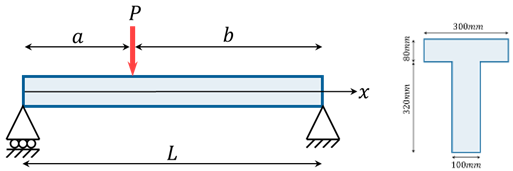

Si tenemos una viga con 𝐸=25000𝑀𝑃𝑎, 𝑎=3𝑚, 𝑏=8𝑚, P=20𝑘𝑁 (hacia abajo). Determinar la deflexión máxima con la teoría de Euler-Bernoulli. Obtener la distribución en la sección transversal de los esfuerzos normales para el momento máximo/mínimo y los esfuerzos cortantes para la fuerza cortante máxima/mínima.

## Importar librerías y crear funciones

In [1]:
from sympy import lambdify, Piecewise, integrate, symbols, Eq, solve
from sympy.abc import x
from numpy import sum, array, linspace, meshgrid, argmin, argmax
import matplotlib.pyplot as plt

In [2]:
# Función con la condición de Macaulay, a: punto de discontinuidad, g:grado
macaulay = lambda a, g : Piecewise(((x-a)**g, (a <= x)), (0, True))

In [3]:
def grafico_funcion_viga(x, f, titulo, momento=False):
    plt.figure(figsize=(10, 3))                   # Tamaño de la gráfica.
    plt.plot(x, f, 'r')                           # Gráfica de la función.
    plt.fill_between(x, f, color="lavenderblush") # Sombreado de la gráfica.
    plt.plot([0, max(x)], [0, 0], 'k')            # Eje x.
    plt.xlabel("Posición [mm]")                   # Título del eje x.
    plt.ylabel(titulo)                            # Título del eje y.
    plt.xlim(0, max(x))                           # Límites en x del gráfico.
    if momento==True:             # Condición si la función es M(x).
        plt.gca().invert_yaxis()  # Invierte el eje y (función).
    plt.show()

def grafico_funcion_esfuerzo_seccion(y, f, titulo):
    plt.figure(figsize=(3, 6))                     # Tamaño de la gráfica.
    plt.plot(f, y, "r")                            # Gráfica de la función.
    plt.fill_betweenx(y,f, color="lavenderblush")  # Sombreado de la gráfica.
    plt.plot([0, 0], [min(y), max(y)], 'k')        # Eje y.
    plt.xlabel(titulo)                             # Título del eje x.
    plt.ylabel("Posición [mm]")                    # Título del eje y.
    plt.ylim(min(yg), max(yg))                     # Límites en x del gráfico.
    plt.show()

def dibujar_esf_def(titulo, f, x, y):
    curvas = linspace(f.min(), f.max(), 20)  # Definimos 20 curvas de nivel.
    plt.figure(figsize=(12, 3))
    im = plt.pcolormesh(x, y, f, vmin=f.min(), vmax=f.max(), shading='gouraud', cmap='jet_r')
    # Se grafica la función con colores.
    plt.contour(x, y, f, levels=curvas, colors='k', linestyles='-', linewidths=0.7)
    plt.colorbar(im, aspect=5)       # Se crea una barra de color lateral.
    plt.ylabel(titulo, fontsize=18)  # Título.
    plt.xlim(x.min(), x.max())       # Límites en x del gráfico.
    plt.ylim(y.min(), y.max())       # Límites en y del gráfico.
    plt.show()

def area_poligono(puntos):
    # Calcular el área.
    area = 0.5 * sum(puntos[:-1, 0] * puntos[1:, 1] -
                     puntos[1:, 0] * puntos[:-1, 1])
    return area

def centroide_y_poligono(puntos):
    # Calcular el centroide y.
    cy = sum((puntos[:-1, 1] + puntos[1:, 1]) *
             (puntos[:-1, 0] * puntos[1:, 1] -
             puntos[1:, 0] * puntos[:-1, 1])) / (6 * area_poligono(puntos))
    return cy

def inercia_x_centroidal_poligono(puntos):
    # Calcular el centroide y
    cy = centroide_y_poligono(puntos)
    # Calcular el momento de inercia respecto al eje centroidal
    inercia = sum((puntos[:-1, 0] * puntos[1:, 1] -
                   puntos[1:, 0] * puntos[:-1, 1]) *
                  ((puntos[:-1, 1] - cy)**2 +
                   (puntos[:-1, 1] - cy) * (puntos[1:, 1] - cy) +
                   (puntos[1:, 1] - cy)**2)) / 12
    return inercia

## Datos de entrada

Sección transversal:

In [4]:
# Se definen los puntos del polígono en sentido antihorario y cerrando en el 1°.
puntos = array([[100, 0], [200, 0], [200, 320], [300, 320], [300, 400],
                [0, 400],[0,320], [100, 320],[100,0]])
ci = centroide_y_poligono(puntos)            # [mm] Fibra inferior.
cs = 400 - ci                                # [mm] Fibra superior.
Icx = inercia_x_centroidal_poligono(puntos)  # [mm^4] Cálculo de la inercia.

In [5]:
x, y = symbols("x, y")        # Variables de posición.
C3, C4 = symbols("C3, C4")    # Constantes de integración.
RA, RB = symbols("R_A, R_B")  # Reacciones.

In [6]:
E = 25000   # [MPa] Módulo de elasticidad de la viga
a = 3*1000  # [mm]  Distancia a la izquierda de la carga.
b = 8*1000  # [mm]  Distancia a la derecha de carga.
L = a+b     # [mm]  Longitud de la viga.
I = Icx     # [mm⁴] Momento de inercia respecto a x.
P = 20000   # [N]   Carga puntual hacia abajo.

Escribimos nuestras ecuaciones de fuerza cortante y momento flector:
$$V(x)=R_A\langle x-0 \rangle^0 - P\langle x-a \rangle^0$$
$$M(x)=R_A\langle x-0 \rangle^1 - P\langle x-a \rangle^1$$

In [7]:
V = RA*macaulay(0, 0) - P*macaulay(a, 0)  # [N] F. cortante del corte único.
M = RA*macaulay(0, 1) - P*macaulay(a, 1)  # [N.mm] Momento del corte único.

In [8]:
t = integrate(M/(E*I), x) + C3  # [RAD] Ángulo de giro.
v = integrate(t,       x) + C4  # [mm] deflexión con Euler-Bernoulli.

In [9]:
sol = solve([Eq(v.subs(x,0), 0),  # Despl vert en apoyo en x=0 es 0.
             Eq(M.subs(x,0), 0),  # Momento flector     en x=0 es 0.
             Eq(v.subs(x,L), 0),  # Despl vert en apoyo en x=11m es 0.
             Eq(M.subs(x,L), 0),  # Momento flector     en x=11m es 0.
             Eq(RA+RB-P,     0),  # Sum fx=0
             Eq(-RA*L+P*b,   0),  # Sum M=0
             ],
            [RA,RB, C3, C4 ])

In [10]:
V = V.subs(sol)
M = M.subs(sol)
t = t.subs(sol)
v = v.subs(sol)

In [11]:
xi, yi = meshgrid(linspace(   0,  L, 1000),  # Dirección x.
                  linspace( -ci, cs, 1000))  # Dirección y, va de -ci hasta cs.

Se definen las ecuaciones de $b(y)$ y $Q(y)$ por tramos, según la estimación a mano:

In [12]:
b1 = 100  # [mm]
b2 = 300  # [mm]
Q1 =  50*(y**2-ci**2)                                    # [mm^3]
Q2 = -(160-(320-ci))*(100*320) + 150*(y**2-(320-ci)**2)  # [mm^3]

In [13]:
b_ = Piecewise((b1, (y <= 320-ci) & (y>=-ci)), (b2, (y >= 320-ci)))
Q  = Piecewise((Q1, (y <= 320-ci) & (y>=-ci)), (Q2, (y >= 320-ci)))

In [14]:
sx  = -M*y/I       # [N/mm^2] Esfuerzo normal.
txy =  V*Q/(I*b_)  # [N/mm^2] Esfuerzo cortante.

Se convierten las ecuaciones a graficar en funciones que nummpy pueda interpretar.

In [15]:
V  = lambdify(x, V, "numpy")
M  = lambdify(x, M, "numpy")
t  = lambdify(x, t, "numpy")
v  = lambdify(x, v, "numpy")

sx  = lambdify((x,y),  sx, "numpy")
txy = lambdify((x,y), txy, "numpy")

In [16]:
xg = xi[0]    # Extraemos la información para funciones que sólo dependen de x.
yg = yi[:,0]  # Extraemos la información para funciones que sólo dependen de y.

## Gráficos de $V(x)$, $M(x)$, $\theta(x)$ y $v(x)$

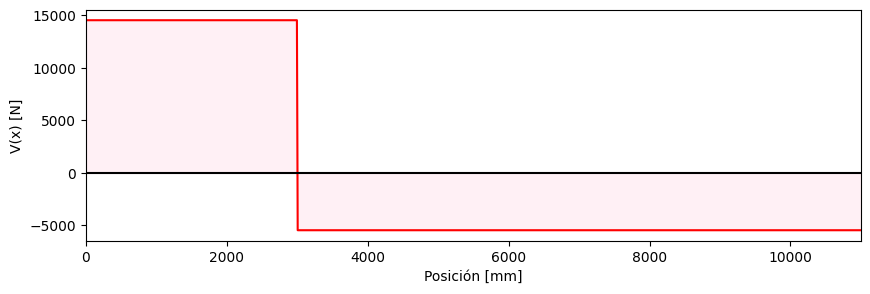

In [17]:
grafico_funcion_viga(xg, V(xg), "V(x) [N]")

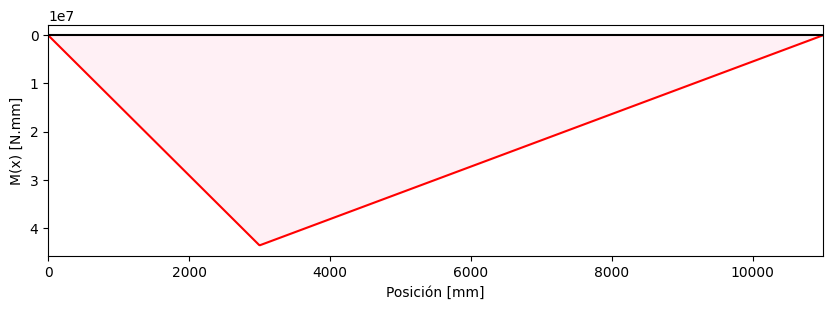

In [18]:
grafico_funcion_viga(xg, M(xg), "M(x) [N.mm]", momento=True)

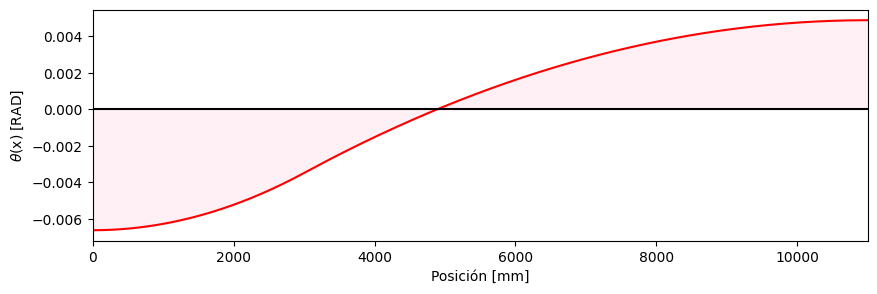

In [19]:
grafico_funcion_viga(xg, t(xg), r"$\theta$(x) [RAD]")

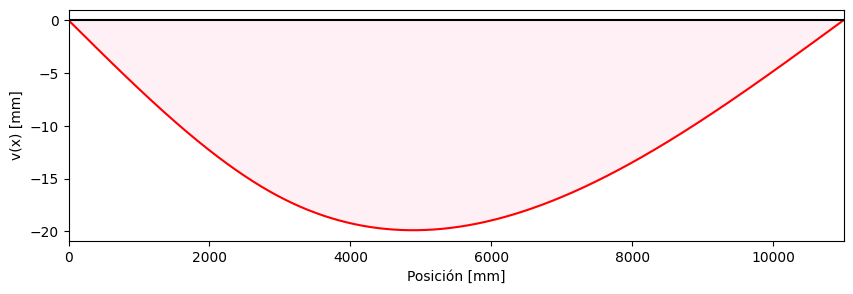

In [20]:
grafico_funcion_viga(xg, v(xg), "v(x) [mm]")

## Gráficos de esfuerzos

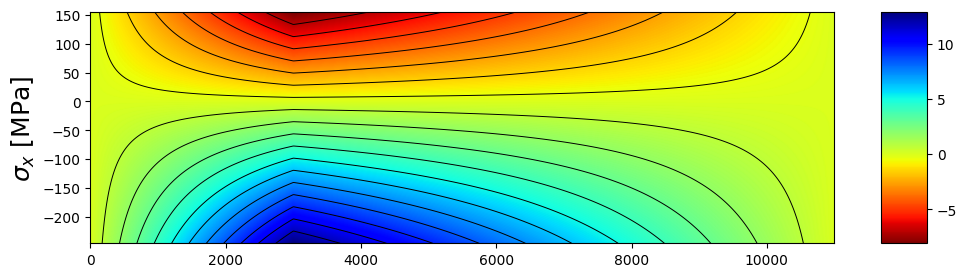

In [21]:
dibujar_esf_def(r"$\sigma_x$ [MPa]", sx(xi,yi), xi, yi)

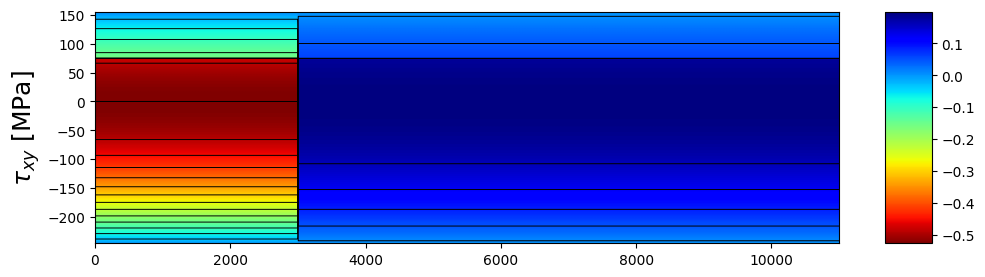

In [22]:
dibujar_esf_def(r"$\tau_{xy}$ [MPa]", txy(xi,yi), xi, yi)

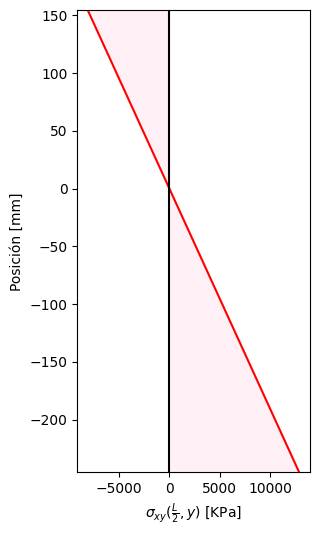

In [23]:
grafico_funcion_esfuerzo_seccion(yg, sx(a,yg)*1000, r"$\sigma_{xy}(\frac{L}{2},y)$ [KPa]")

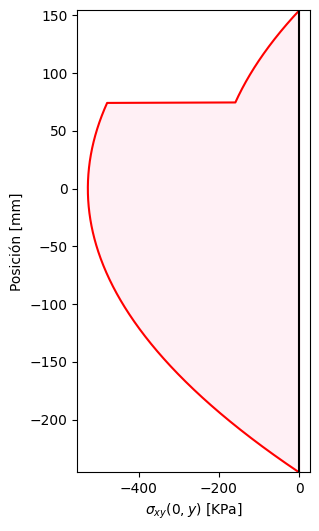

In [24]:
grafico_funcion_esfuerzo_seccion(yg, txy(0,yg)*1000, r"$\sigma_{xy}(0,y)$ [KPa]")

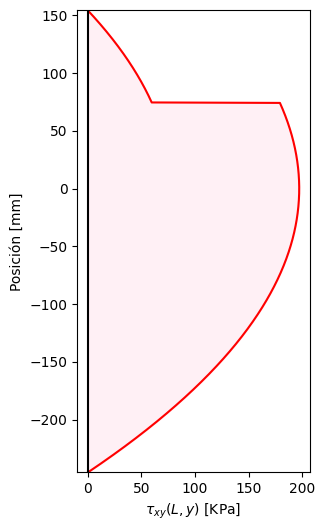

In [25]:
grafico_funcion_esfuerzo_seccion(yg, txy(L,yg)*1000, r"$\tau_{xy}(L,y)$ [KPa]")

## Conclusiones

In [26]:
print(f"La fuerza cortante máxima positiva es {round(max(V(xg)),2)}N en 0<=x<a")
print(f"La fuerza cortante máxima negativa es {round(min(V(xg)),2)}N en a<=x<=L")

La fuerza cortante máxima positiva es 14545.45N en 0<=x<a
La fuerza cortante máxima negativa es -5454.55N en a<=x<=L


In [27]:
print(f"El esfuerzo cortante máximo negativo es {round(txy(0, 0)*1000,2)}kPa en la posición (x,0) para 0<=x<a")
print(f"El esfuerzo cortante máximo positivo es {round(txy(L, 0)*1000,2)}kPa en la posición (x,0) para a<=x<=L")

El esfuerzo cortante máximo negativo es -526.22kPa en la posición (x,0) para 0<=x<a
El esfuerzo cortante máximo positivo es 197.33kPa en la posición (x,0) para a<=x<=L


In [28]:
print(f"El momento flector máximo positivo es {round(max(M(xg)),2)}N.mm en la posición x={round(xg[argmax(M(xg))],1)}")
print(f"El momento flector máximo negativo es {round(min(M(xg)),2)}N.mm en la posición x={round(xg[argmin(M(xg))],1)}")

El momento flector máximo positivo es 43603603.6N.mm en la posición x=3006.0
El momento flector máximo negativo es -0.0N.mm en la posición x=11000.0


In [29]:
print(f"El esfuerzo máximo a compresión es {abs(round(sx(cs, a)*1000,2))}kPa en la posición (cs,a).")
print(f"El esfuerzo máximo a tracción es {abs(round(sx(ci, a)*1000,2))}kPa en la posición (ci,a).")

El esfuerzo máximo a compresión es 8068.26kPa en la posición (cs,a).
El esfuerzo máximo a tracción es 12849.46kPa en la posición (ci,a).


In [30]:
print(f"El desplazamiento máximo positivo es {round(max(v(xg)),2)}mm en la posición x={round(xg[argmax(v(xg))],1)}")
print(f"El desplazamiento máximo negativo es {round(min(v(xg)),2)}mm en la posición x={round(xg[argmin(v(xg))],1)}")

El desplazamiento máximo positivo es 0.0mm en la posición x=11000.0
El desplazamiento máximo negativo es -19.88mm en la posición x=4888.9
